# HANet for handover

This notebook is to show how to train HANet and visulize the  grasping estimation.
Our network is a FCN whose backbone is ResNet-101 and pre-trianed by [ImageNet](https://www.image-net.org/download.php).

In [1]:
# default_exp other_model

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
# export 
import torch
import torch.nn as nn
import torchvision
import copy
import cv2
import sys
import numpy as np
from PIL import Image
from PIL import ImageDraw
import simplejson as json

# Rosenberger
# ref:https://github.com/patrosAT/h2r_handovers
sys.path.append('/home/arg/ggcnn_humanseg_ros/src/helper_ggcnn')
from ggcnn import predict
from pre_processing import Preparations

# DOPE
# ref:https://github.com/NVlabs/Deep_Object_Pose
sys.path.append('/home/arg/Deep_Object_Pose/scripts/train2')
sys.path.append('/home/arg/Deep_Object_Pose/scripts/train2/inference')
sys.path.append('/home/arg/Deep_Object_Pose/src/dope/inference')
from cuboid import Cuboid3d
from cuboid_pnp_solver import CuboidPNPSolver
from inference import DopeNode, Draw
from detector import ModelData, ObjectDetector, DopeNetwork


# ref:https://github.com/patrosAT/ggcnn_humanseg_ros/blob/master/src/helper_ggcnn/ggcnn.py   
class GGCNN():
    def __init__(self):
        self.prep = Preparations()
        self.scale = 300
        self.out_height = 480 
        self.out_width = 640
        
        
    def largest_indices(self, array, n):
        """Returns the n largest indices from a numpy array.
        
        This function return top-n index from given numpy array.
        
        Args:
            array (ndarray) : source array.
            n (int) : num of index to return.
            
        Returns:
            index
        
        """
        flat = array.flatten()
        indices = np.argpartition(flat, -n)[-n:]
        indices = indices[np.argsort(-flat[indices])]
        
        return np.unravel_index(indices, array.shape)
    
    def angle_translater(self, angle, idx):
        """Remap angle.
        
        This function will get a specific index in pixel-wise angle numpy array and transfer from radius to degrees.
        
        Args:
            angle (ndarray) : angle in radius.
            idx (list) : target index of angle array.
            
        Returns:
            angle (degrees)
        
        """
        angle = (angle + np.pi/2) % np.pi - np.pi/2
        angle = angle[idx] *180/np.pi

        return angle

        
    def pred_grasp(self,depth, depth_nan, mask_body, mask_hand, bbox):
        """Get pixel-wise prediction result of grasping point and angle."""
        depth_bg, mask_bg = self.prep.prepare_image_mask(depth=depth, depth_nan=depth_nan, 
                                                    mask_body=mask_body, mask_hand=mask_hand, 
                                                    dist_obj=bbox[4], dist_ignore=1.0, 
                                                    grip_height=0.08)
        
        depth_ggcnn = cv2.resize(depth_bg,(self.scale,self.scale))
        mask_ggcnn = cv2.resize(mask_bg,(self.scale,self.scale))
        
        points, angle, width_img, _ = predict(depth=depth_ggcnn, mask=mask_ggcnn,
                                            crop_size=self.scale, out_size=self.scale, 
                                            crop_y_offset=40, filters=(2.0, 2.0, 2.0))
        
        return points, angle, width_img
    
    def get_grasp_pose(self, points, angle, width_img, top_n = 1):
        """Get Top-N prediction result
        
        This function will return top-n grasping parameter x, y, theta.
        
        Args:
            points (ndarray) : pixel-wise grasping point prediction by ggcnn.
            angle (ndarray) : pixel-wise grasping angle prediction by ggcnn.
            width_img (ndarray) : pixel-wise width_img prediction by ggcnn.
            top_n (int) : num of Top-N.
        
        Returns:
            list of Top-N result:[x, y, theta]
        """
        best_g = self.largest_indices(points, top_n)
        out_list = []
        for i in range(top_n):
            best_g_unr = (best_g[0][i], best_g[1][i])
            Angle = self.angle_translater(angle, best_g_unr)
            resize_point = [best_g_unr[0]*(self.out_height/self.scale), best_g_unr[1]*(self.out_width/self.scale)]
            
            x = int(resize_point[1])
            y = int(resize_point[0])
            theta = Angle
            
            out_list.append([x, y, theta])
            
        return out_list

# ref:https://github.com/andyzeng/arc-robot-vision
class ConvNet(nn.Module):
    def __init__(self, n_classes):
        super(ConvNet, self).__init__()
        self.color_trunk = torchvision.models.resnet101(pretrained=True)
        del self.color_trunk.fc, self.color_trunk.avgpool, self.color_trunk.layer4
        self.depth_trunk = copy.deepcopy(self.color_trunk)
        self.conv1 = nn.Conv2d(2048, 512, 1)
        self.conv2 = nn.Conv2d(512, 128, 1)
        self.conv3 = nn.Conv2d(128, n_classes, 1)
    def forward(self, color, depth):
        # Color
        color_feat_1 = self.color_trunk.conv1(color) # 3 -> 64
        color_feat_1 = self.color_trunk.bn1(color_feat_1)
        color_feat_1 = self.color_trunk.relu(color_feat_1)
        color_feat_1 = self.color_trunk.maxpool(color_feat_1) 
        color_feat_2 = self.color_trunk.layer1(color_feat_1) # 64 -> 256
        color_feat_3 = self.color_trunk.layer2(color_feat_2) # 256 -> 512
        color_feat_4 = self.color_trunk.layer3(color_feat_3) # 512 -> 1024
        # Depth
        depth_feat_1 = self.depth_trunk.conv1(depth) # 3 -> 64
        depth_feat_1 = self.depth_trunk.bn1(depth_feat_1)
        depth_feat_1 = self.depth_trunk.relu(depth_feat_1)
        depth_feat_1 = self.depth_trunk.maxpool(depth_feat_1) 
        depth_feat_2 = self.depth_trunk.layer1(depth_feat_1) # 64 -> 256
        depth_feat_3 = self.depth_trunk.layer2(depth_feat_2) # 256 -> 512
        depth_feat_4 = self.depth_trunk.layer3(depth_feat_3) # 512 -> 1024
        # Concatenate
        feat = torch.cat([color_feat_4, depth_feat_4], dim=1) # 2048
        feat_1 = self.conv1(feat)
        feat_2 = self.conv2(feat_1)
        feat_3 = self.conv3(feat_2)
        return nn.Upsample(scale_factor=2, mode="bilinear")(feat_3)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Rosenberger Inference
### ref:https://github.com/patrosAT/h2r_handovers

In [1]:
from handover_grasping.Datavisualizer import rosenberger_dataloader
from handover_grasping.other_model import GGCNN
from handover_grasping.utils import get_grasp_line
import cv2
import torch
from matplotlib import pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load Data

Do inference on HANet Easy Testing datasets.

In [2]:
hanet_easy_loader = rosenberger_dataloader('/home/arg/handover_grasping/data/HANet_easy_datasets')

### Initial GGCNN

Load ggcnn with pre-trained weight.

In [3]:
ggcnn = GGCNN()

### Get sample data

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


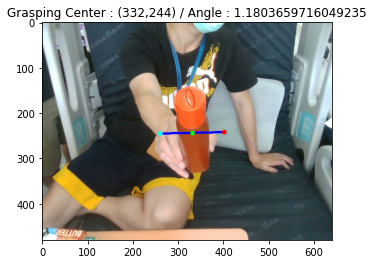

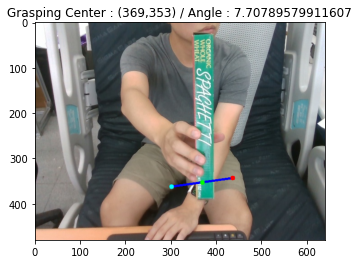

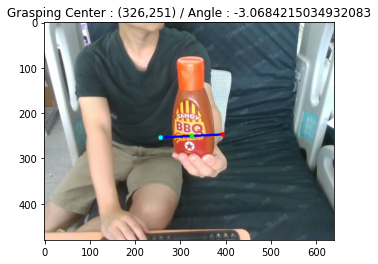

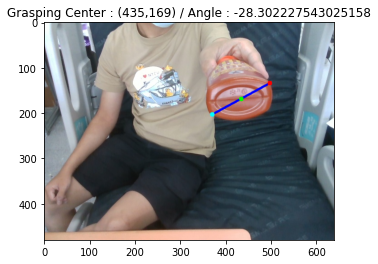

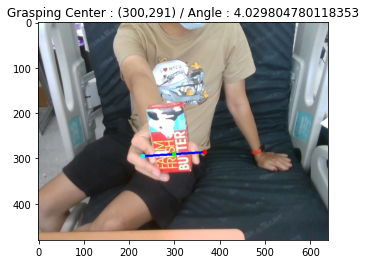

In [4]:
SHOW_NUM = 5

for _ in range(SHOW_NUM): 
    # Get sample data
    batch = hanet_easy_loader.get_next_data(vis_bbox=True)
    color = batch['color']
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    color_bbox = batch['color_bbox']
    depth = batch['depth']
    depth_nan = batch['depth_nan']
    mask_hand = batch['mask_hand']
    mask_body = batch['mask_body']
    bbox = batch['bbox']
    
    # Predict grasping pose by GGCNN
    with torch.no_grad():
        points, angle, width_img = ggcnn.pred_grasp(depth, depth_nan, mask_body, mask_hand, bbox)
    output = ggcnn.get_grasp_pose(points, angle, width_img)
    
    # Prediction result : x, y, theta
    x = output[0][0]
    y = output[0][1]
    theta = output[0][2]

    # Visualize prediction result
    depth_ = depth*1000.0

    point1, point2 = get_grasp_line(theta, [y, x], depth_)

    Result = cv2.line(color,point1,point2,(0,0,255),3)
    Result = cv2.circle(Result, (int(x), int(y)), 5, (0,255,0), -1)
    Result = cv2.circle(Result, point1, 5, (255,0,0), -1)
    Result = cv2.circle(Result, point2, 5, (0,255,255), -1)

    plt.imshow(Result)
    plt.title("Grasping Center : ({},{}) / Angle : {}".format(x, y, theta))
    plt.show()

## DOPE Inference
### ref:https://github.com/NVlabs/Deep_Object_Pose

In [1]:
from PIL import Image
from PIL import ImageDraw
import argparse
import yaml 
import glob
import os
import time
import sys
import cv2
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models

from handover_grasping.other_model import DopeNetwork, Draw, DopeNode

### Set parameters

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--pause",
    default=0,
    help='pause between images')
parser.add_argument("--showbelief",
    action="store_true",
    help='show the belief maps')
parser.add_argument("--dontshow",
    action="store_true",
    help='headless mode')
parser.add_argument("--outf",
    default="out_experiment",
    help='where to store the output')
parser.add_argument("--data",
    default='*.png',
    help='folder for data images to load, *.png, *.jpeg, *jpg')
parser.add_argument("--config",
    default="/home/arg/handover_grasping/config/config_pose.yaml",
    help='folder for the inference configs')
parser.add_argument("--camera",
    default="/home/arg/handover_grasping/config/camera_info.yaml",
    help='camera info file')
parser.add_argument('--realsense',
    action='store_true',
    help='use the realsense camera')

opt = parser.parse_args([])

### Load config

In [3]:
with open(opt.config) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
with open(opt.camera) as f:
    camera_info = yaml.load(f, Loader=yaml.FullLoader)
    
if opt.realsense:
    import pyrealsense2 as rs
    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

    # Start streaming
    pipeline.start(config)
    
print (f"output is located in {opt.outf}")
try:
    shutil.rmtree(f"{opt.outf}")
except:
    pass

try:
    os.makedirs(f"{opt.outf}")
except OSError:
    pass

output is located in out_experiment


### Load testing data and pre-trained weight

In [4]:
# load the images if there are some
path = '/home/arg/handover_grasping/data/Dope_testing'
f = open(path+'/test.txt', "r")
imgs = []
imgsname = []
for i, line in enumerate(f):
    id = line.replace("\n", "")
    imgs.append(path+'/color/color_'+id+'.png')
    imgsname.append('color_'+id)

if not opt.data is None:
    videopath = opt.data
    for j in sorted(glob.glob(videopath+"/*.png")):
        imgs.append(j)
        imgsname.append(j.replace(videopath,"").replace("/",""))
else:
    if not opt.realsense:
        cap = cv2.VideoCapture(0)

# An object to run dope node
dope_node = DopeNode(config)

{'Spaghetti': '/home/arg/handover_grasping/model/DOPE_pretrained_weight/Spaghetti.pth', 'mustard': '/home/arg/handover_grasping/model/DOPE_pretrained_weight/mustard_60.pth', 'Butter': '/home/arg/handover_grasping/model/DOPE_pretrained_weight/Butter.pth', 'BBQSauce': '/home/arg/handover_grasping/model/DOPE_pretrained_weight/BBQSauce.pth', 'Mayo': '/home/arg/handover_grasping/model/DOPE_pretrained_weight/Mayo.pth', 'Popcorn': '/home/arg/handover_grasping/model/DOPE_pretrained_weight/Popcorn.pth', 'soup': '/home/arg/handover_grasping/model/DOPE_pretrained_weight/soup_60.pth', 'Raisins': '/home/arg/handover_grasping/model/DOPE_pretrained_weight/Raisins.pth', 'ChocolatePudding': '/home/arg/handover_grasping/model/DOPE_pretrained_weight/ChocolatePudding.pth', 'sugar': '/home/arg/handover_grasping/model/DOPE_pretrained_weight/sugar_60.pth'}
Spaghetti
Loading DOPE model '/home/arg/handover_grasping/model/DOPE_pretrained_weight/Spaghetti.pth'...
    Model loaded in 5.163791656494141 seconds.
lo

### Make Prediction

frame color_0


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


[19.037339851388285, 4.888362739184063, 59.64332569416443]


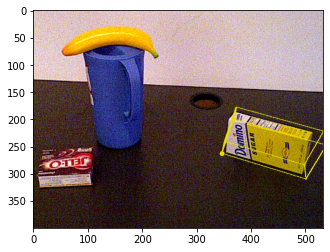

frame color_1
[-6.692330948808362, 4.277444174296157, 53.15505611991283]
[-15.3917636747234, 2.3231789243520593, 67.88542393889713]
[-6.152686703149978, 12.142048340869323, 67.3808791665442]


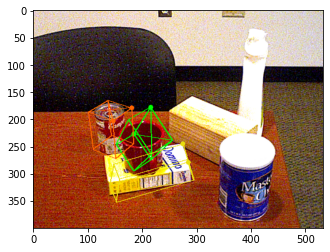

frame color_2


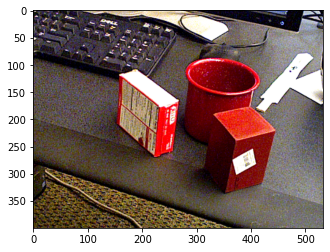

frame color_3
[16.848446761687583, 3.4448381315685372, 70.17456548954411]
[12.682607212991357, 14.329618716814224, 59.35460339294482]


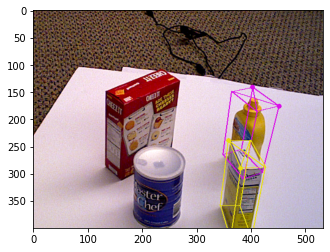

frame color_4
[-6.8328089170885695, 24.688611226634407, 170.89269773796207]
[-7.415664196461492, -9.502295347766562, 68.23371964582688]


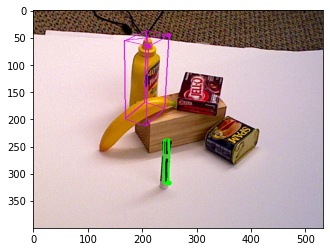

In [5]:
# MAX 92
SHOW_NUM = 5

for i in range(SHOW_NUM):
    frame = cv2.imread(imgs[i])
    print(f"frame {imgsname[i]}")
    img_name = imgsname[i]

    frame = frame[...,::-1].copy()

    # call the inference node
    dope_node.image_callback(
    frame, 
    camera_info,
    img_name = img_name,
    output_folder = opt.outf)

    result = cv2.imread('/home/arg/handover_grasping/out_experiment/color_'+str(i)+'.png')
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.imshow(result)
    plt.show()

## ConvNet Inference
### ref:https://github.com/andyzeng/arc-robot-vision

In [1]:
import cv2
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import  DataLoader
from handover_grasping.Datavisualizer import parallel_jaw_based_grasping_dataset
from handover_grasping.utils import get_grasp_line, get_affordancemap, Image_table
from handover_grasping.model import ConvNet

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load data

Do inference on parallel-jaw-grasping-dataset.

In [2]:
dataset = parallel_jaw_based_grasping_dataset('/home/arg/handover_grasping/data/parallel-jaw-grasping-dataset', use_zeng=True)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = False, num_workers = 1)

### Initial ConvNet with pre-trained weight

Load ConvNet with pre-trained weight trained on parallel-jaw-grasping-dataset.

In [3]:
net = ConvNet(3)
net = net.cuda()
net.load_state_dict(torch.load('/home/arg/handover_grasping/model/baseline-graspnet.pth'))
net.eval()

ConvNet(
  (color_trunk): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

### Get sample data

In [4]:
batch = next(iter(dataloader))

# RGB and Depth image list, each contain 16 images
colors = batch['color']
depths = batch['depth']

colors_origin = batch['color_origin']
depths_origin = batch['depth_origin']

### Make prediction

This cell will rotate input images 15 times and do inference, this is to find the object angle by select the maximum prediction value of 16 predictions.

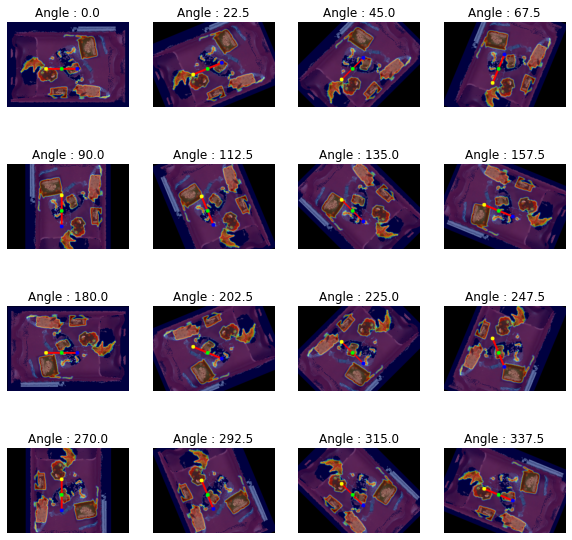

In [7]:
aff_list = []
title_list = []
value_list = []
coord_list = []
for i in range(16):
    color = colors[i].cuda()
    depth = depths[i].cuda()
    
    with torch.no_grad():
        predict = net.forward(color, depth)
        
    Depth = depths_origin[0][0].numpy()
    
    value = np.max(predict[0,2].cpu().numpy())

    affordanceMap, x, y = get_affordancemap(predict, Depth, True)

    color = colors_origin[i][0].numpy().astype('uint8')

    center = (int(color.shape[1]/2), int(color.shape[0]/2))
    M = cv2.getRotationMatrix2D(center, i*22.5, 1.0)
    affordanceMap = cv2.warpAffine(affordanceMap, M, (color.shape[1], color.shape[0]))
    
    value_list.append(value)

    Combine = cv2.addWeighted(color,0.5,affordanceMap, 0.5,0)
    
    theta = i*22.5

    point1, point2 = get_grasp_line(theta, [y, x], Depth)

    Combine = cv2.line(Combine,point1,point2,(0,0,255),3)
    Combine = cv2.circle(Combine, (int(x), int(y)), 5, (0,255,0), -1)
    Combine = cv2.circle(Combine, point1, 5, (255,0,0), -1)
    Combine = cv2.circle(Combine, point2, 5, (0,255,255), -1)
    
    aff_list.append(Combine[:,:,[2,1,0]])
    title_list.append('Angle : '+str(i*22.5))
    coord_list.append([x, y])

# show result
Image_table(4,4,aff_list,title_list)

### Select Max angle
Select the maximum prediction value from 16 predictions to find the object angle

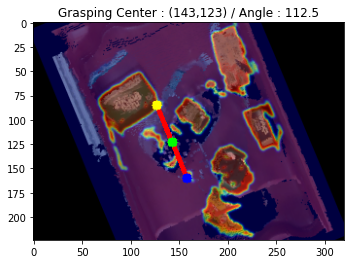

In [8]:
max_id = value_list.index(max(value_list))
x = coord_list[max_id][0]
y = coord_list[max_id][1]
plt.imshow(aff_list[max_id])
plt.title("Grasping Center : ({},{}) / Angle : {}".format(x, y, max_id*22.5))
plt.show()